# Test saturation of amino acid substitution

## Background

**Saturation** of amino acid substitution potentially leads to the under-estimation of phylogenetic distance. To test how this impacts our phylogenetic trees, especially the relative distance between the Archaea and Bacteria domains, we calculated and analyzed the the ratio of Hamming distance between sequences vs. phylogenetic distance between taxa (sum of branch lengths).

The principles of saturation test were detailed in [Jeffroy et al. (2006)](https://www.sciencedirect.com/science/article/pii/S0168952506000515).

## Preliminary analyses

- `phylo_distmat.py` computes the sum of branch lengths between each pair of taxa in the phylogenetic tree.
- `align_distmat.py` computes the Hamming distance between each pair of sequences in the concatenated alignment.
- `sample_ab_dists.py` randomly samples *k* taxa from each of the Archaea and Bacteria domains. It extracts the pairwise phylogenetic and sequential distances among the 2*k* taxa, and categorizes taxon pairs into "AA", "BB" and "AB".


## Preparation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [2]:
%matplotlib inline

## Analysis

In [3]:
table_fp = 'astral.cons.hamming/result.100.tsv.bz2'

In [4]:
df = pd.read_table(table_fp, index_col=0)
df.head()

,phy,seq,group
0,1.86670,0.56058,AB
1,1.48027,0.44219,BB
2,1.40161,0.41009,BB
3,1.33363,0.40544,BB
4,1.93589,0.57145,AB


### Linear regression of all pairwise distances

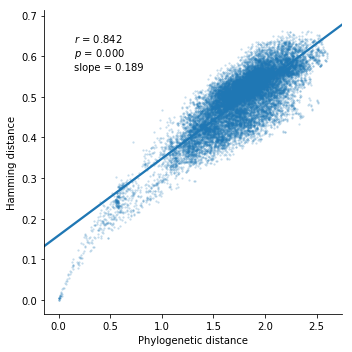

In [5]:
reg = sp.stats.linregress(df[['phy', 'seq']].values)
g = sns.lmplot(x='phy', y='seq', scatter_kws={'alpha': 0.25, 's': 5, 'lw': 0}, data=df)
ax = plt.gca()
ax.text(0.1, 0.8, '$\it{r}$ = %.3f\n$\it{p}$ = %.3f\nslope = %.3f'
        % (reg.rvalue, reg.pvalue, reg.slope), transform=ax.transAxes)
ax.set_xlabel('Phylogenetic distance')
ax.set_ylabel('Hamming distance');

In [6]:
fig = g.fig
fig.tight_layout()
fig.savefig('scatter.all.pdf', bbox_to_inches='tight')

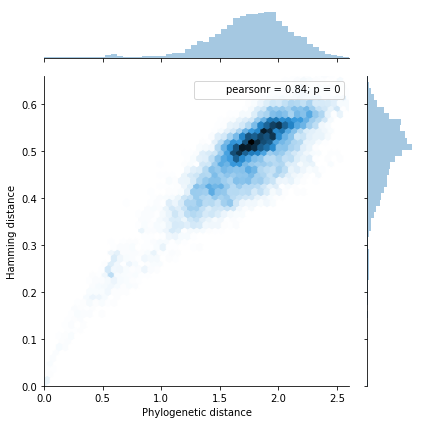

In [7]:
g = sns.jointplot(x='phy', y='seq', kind='hex', data=df)
g.set_axis_labels('Phylogenetic distance', 'Hamming distance')
fig = g.fig
fig.tight_layout()
fig.savefig('hex.all.pdf', bbox_to_inches='tight')

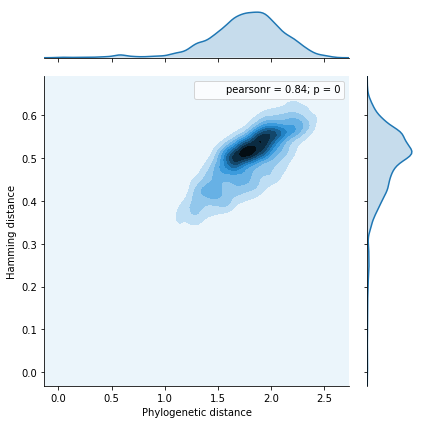

In [8]:
g = sns.jointplot(x='phy', y='seq', kind='kde', data=df)
g.set_axis_labels('Phylogenetic distance', 'Hamming distance')
fig = g.fig
fig.tight_layout()
fig.savefig('kde.all.pdf', bbox_to_inches='tight')

### Highlighting and regression by catalog

In [9]:
gb = df.groupby('group')
groups = list(gb.groups)
dfs = [gb.get_group(x) for x in groups]

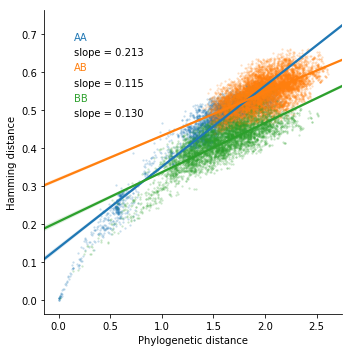

In [10]:
regs = [sp.stats.linregress(x[['phy', 'seq']].values) for x in dfs]
g = sns.lmplot(x='phy', y='seq', hue='group', hue_order=groups, data=df,
               scatter_kws={'alpha': 0.25, 's': 5, 'lw': 0}, legend=False)
ax = plt.gca()
for i in range(len(regs)):
    ax.text(0.1, 0.9 - i * 0.1, groups[i], color=sns.color_palette()[i], transform=ax.transAxes)
    ax.text(0.1, 0.85 - i * 0.1, 'slope = %.3f' % regs[i].slope, transform=ax.transAxes)
ax.set_xlabel('Phylogenetic distance')
ax.set_ylabel('Hamming distance');

In [11]:
fig = g.fig
fig.tight_layout()
fig.savefig('scatter.3.pdf', bbox_to_inches='tight')

### Narrow down the comparison range

In [12]:
for i, group in enumerate(groups):
    print('%s: ' % group + str({k: '%.3g' % v for k, v in dict(dfs[i]['phy'].describe()).items()}))

AA: {'count': '4.95e+03', 'mean': '1.55', 'std': '0.38', 'min': '1e-05', '25%': '1.43', '50%': '1.63', '75%': '1.79', 'max': '2.16'}
AB: {'count': '1e+04', 'mean': '1.96', 'std': '0.226', 'min': '1.4', '25%': '1.79', '50%': '1.95', '75%': '2.12', 'max': '2.61'}
BB: {'count': '4.95e+03', 'mean': '1.57', 'std': '0.332', 'min': '0.0153', '25%': '1.34', '50%': '1.57', '75%': '1.8', 'max': '2.52'}


Upper and lower limits arbitrarily determined based on the distributions.

In [13]:
phymin, phymax = 1.2, 2.4

In [14]:
dfx = df.query('%s < phy < %s' % (phymin, phymax))

In [15]:
gbx = dfx.groupby('group')
dfxs = [gbx.get_group(x) for x in groups]

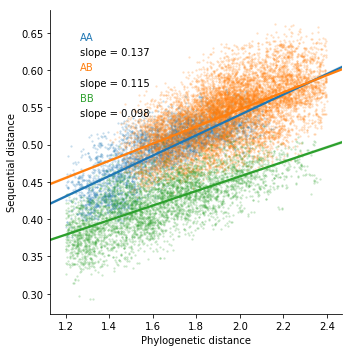

In [16]:
regx = [sp.stats.linregress(x[['phy', 'seq']].values) for x in dfxs]
g = sns.lmplot(x='phy', y='seq', hue='group', hue_order=groups, data=dfx,
               scatter_kws={'alpha': 0.25, 's': 5, 'lw': 0}, legend=False)
ax = plt.gca()
for i, reg in enumerate(regx):
    ax.text(0.1, 0.9 - i * 0.1, groups[i], color=sns.color_palette()[i], transform=ax.transAxes)
    ax.text(0.1, 0.85 - i * 0.1, 'slope = %.3f' % reg.slope, transform=ax.transAxes)
ax.set_xlabel('Phylogenetic distance')
ax.set_ylabel('Sequential distance');

In [17]:
fig = g.fig
fig.tight_layout()
fig.savefig('scatter.3.lim.pdf', bbox_to_inches='tight')

### Normalize sub-populations prior to comparison

In [18]:
for x in dfs:
    x['phys'] = scale(x['phy'])
dfx = pd.concat(dfs)

/Users/qiz173/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


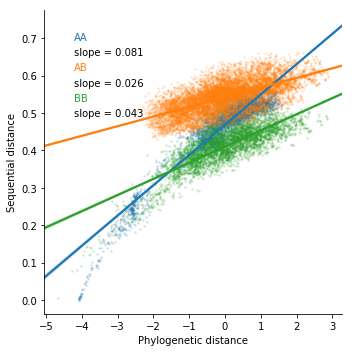

In [19]:
regx = [sp.stats.linregress(x[['phys', 'seq']].values) for x in dfs]
g = sns.lmplot(x='phys', y='seq', hue='group', hue_order=groups, data=dfx,
               scatter_kws={'alpha': 0.25, 's': 5, 'lw': 0}, legend=False)
ax = plt.gca()
for i, reg in enumerate(regx):
    ax.text(0.1, 0.9 - i * 0.1, groups[i], color=sns.color_palette()[i], transform=ax.transAxes)
    ax.text(0.1, 0.85 - i * 0.1, 'slope = %.3f' % reg.slope, transform=ax.transAxes)
ax.set_xlabel('Phylogenetic distance')
ax.set_ylabel('Sequential distance');

In [20]:
fig = g.fig
fig.tight_layout()
fig.savefig('scatter.3.scale.pdf', bbox_to_inches='tight')

### Binning phylogenetic distance

In [21]:
des = df['phy'].describe()
des

count    19900.000000
mean         1.757958
std          0.358225
min          0.000010
25%          1.574685
50%          1.792880
75%          1.990857
max          2.605530
Name: phy, dtype: float64

In [22]:
window = 0.1
start = des['mean'] - des['std'] * 2
end = des['mean'] + des['std'] * 2
steps = int((end - start) / window)
start, end, steps

(1.0415084205574536, 2.4744071904978222, 14)

In [23]:
start = round(start, 1)

### Inter-domain vs intra-domain comparison per bin

In [24]:
df1 = df.query('group == "AB"')
df2 = df.query('group != "AB"')

In [25]:
res = []
for i in range(0, steps, 1):
    bin_ = round(i * window + start, 2)
    x1 = df1.query('%s <= phy < %s' % (bin_, bin_ + window))['seq']
    x2 = df2.query('%s <= phy < %s' % (bin_, bin_ + window))['seq']
    n1, n2 = len(x1), len(x2)
    if min(n1, n2) < 5:
        continue
    u = sp.stats.mannwhitneyu(x1, x2)
    mean1, mean2 = x1.mean(), x2.mean()
    res.append([bin_, n1, n2, round(mean1, 3), round(mean2, 3), round(mean1 / mean2, 3),
                int(u.statistic), '%.3g' % u.pvalue])
res = pd.DataFrame(res, columns=[
    'bin', 'n.inter', 'n.intra', 'mean.inter', 'mean.intra', 'ratio', 'Mann–Whitney U', 'p-value'])
res

,bin,n.inter,n.intra,mean.inter,mean.intra,ratio,Mann–Whitney U,p-value
0,1.4,72,1115,0.495,0.434,1.141,7880,1.28e-30
1,1.5,462,1184,0.494,0.448,1.103,118609,8.99e-72
2,1.6,946,1275,0.505,0.467,1.080,302057,1.57e-90
3,1.7,1105,1382,0.516,0.482,1.071,408186,4.88e-89
4,1.8,1540,1018,0.532,0.486,1.094,331192,1.3e-135
5,1.9,1771,656,0.545,0.491,1.111,174110,2.1e-155
6,2.0,1410,430,0.553,0.494,1.120,80749,5.86e-118
7,2.1,1139,141,0.563,0.475,1.183,6292,9.45e-72
8,2.2,872,74,0.576,0.476,1.211,196,3.95e-46
9,2.3,441,22,0.582,0.470,1.238,0,1.19e-15


In [26]:
res.to_csv('compare.2.tsv', sep='\t')

### Three-way comparison per bin

In [27]:
res = []
for i in range(0, steps, 1):
    bin_ = round(i * window + start, 2)
    xs = [x.query('%s <= phy < %s' % (bin_, bin_ + window))['seq'] for x in dfs]
    ns = [len(x) for x in xs]
    if min(ns) < 5:
        continue
    h = sp.stats.kruskal(xs[0], xs[1], xs[2])
    means = [x.mean() for x in xs]
    res.append([bin_, ns[0], ns[1], ns[2], round(means[0], 3), round(means[1], 3), round(means[2], 3),
                int(h.statistic), '%.3g' % h.pvalue])
res = pd.DataFrame(res, columns=[
    'bin', 'n.AA', 'n.AB', 'n.BB', 'mean.AA', 'mean.AB', 'mean.BB', 'Kruskal-Wallis H', 'p-value'])
res

,bin,n.AA,n.AB,n.BB,mean.AA,mean.AB,mean.BB,Kruskal-Wallis H,p-value
0,1.4,545,72,570,0.459,0.495,0.409,555,2.52e-121
1,1.5,588,462,596,0.485,0.494,0.412,1044,1.3e-227
2,1.6,736,946,539,0.498,0.505,0.426,1175,6.79e-256
3,1.7,834,1105,548,0.511,0.516,0.437,1236,3.97e-269
4,1.8,582,1540,436,0.520,0.532,0.441,1114,8.04e-243
5,1.9,347,1771,309,0.525,0.545,0.453,907,7.33e-198
6,2.0,196,1410,234,0.532,0.553,0.461,663,8.23e-145
7,2.1,21,1139,120,0.532,0.563,0.466,331,8.91e-73


In [28]:
res.to_csv('compare.3.tsv', sep='\t')

In [29]:
bins = np.arange(float(res['bin'].head(1)), float(res['bin'].tail(1)), window)
labels = [str(x) for x in bins]
bins = np.append(bins, bins[-1] + window)

In [30]:
df['bin'] = pd.cut(df['phy'], bins=bins, labels=labels)
df.head()

,phy,seq,group,bin
0,1.86670,0.56058,AB,1.8
1,1.48027,0.44219,BB,1.4
2,1.40161,0.41009,BB,1.4
3,1.33363,0.40544,BB,NaN
4,1.93589,0.57145,AB,1.9


In [31]:
mpl.rcParams['figure.figsize'] = (10, 3)

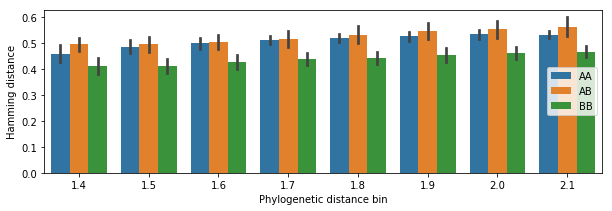

In [32]:
ax = sns.barplot(x='bin', y='seq', hue='group', ci='sd', hue_order=groups, data=df)
plt.ylim(0,)
plt.xlabel('Phylogenetic distance bin')
plt.ylabel('Hamming distance')
plt.legend(loc='right');

In [33]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('compare.3.pdf', bbox_to_inches='tight')